In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import torch
import nltk
from nltk.tokenize import word_tokenize
import re
from sklearn.preprocessing import LabelEncoder
import spacy
from spacy.tokenizer import Tokenizer
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data_set_DataMining/Data_labels.csv')

In [5]:
df 

,Image_name,level
0,IMG_1,4
1,IMG_2,4
2,IMG_3,4
3,IMG_4,4
4,IMG_5,4
...,...,...
511,IMG_512,2
512,IMG_513,2
513,IMG_514,2
514,IMG_515,2


In [6]:
k_list = []
for i in df['Image_name']:
  image = cv2.imread('/content/drive/MyDrive/Data_set_DataMining/Images/' + i + ".jpg")
  image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  k_list.append(image.flatten())

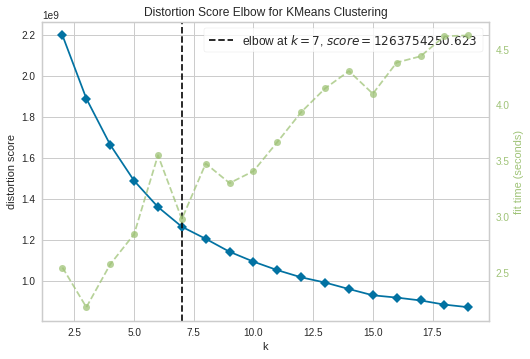

In [7]:
m = KMeans()
v = KElbowVisualizer(m, k=(2, 20))
v.fit(np.array(k_list))
v.show()

In [8]:
df_temp = df["Image_name"]

In [9]:
k = 7
clusters = KMeans(k, random_state = 40)
clusters.fit(k_list)
image_cluster = pd.DataFrame(df_temp, columns = ['Image_name'])
image_cluster["level"] = clusters.labels_
image_cluster

,Image_name,level
0,IMG_1,5
1,IMG_2,5
2,IMG_3,2
3,IMG_4,3
4,IMG_5,5
...,...,...
511,IMG_512,4
512,IMG_513,3
513,IMG_514,2
514,IMG_515,3


In [10]:
df = image_cluster.copy()

In [11]:
df_new = pd.DataFrame(columns = ["Image_name", "level"])
for i in df["level"].unique():
  temp = df[df["level"] == i]
  f = int(len(temp)*0.7)
  df_new = pd.concat([df_new, df.sample(n = f)])

In [12]:
df_new.reset_index(inplace = True, drop = True)

In [13]:
df = df_new

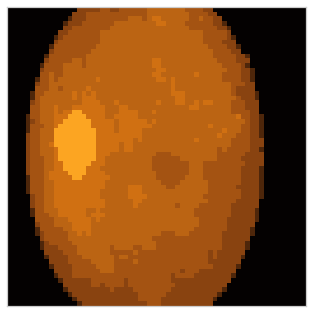

In [14]:
images = []
for i in df.Image_name:
  image = cv2.imread("/content/drive/MyDrive/Data_set_DataMining/Images/" + i + ".jpg")
  image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)

  pixel_values = image.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

  k = 7
  retval, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  centers = np.uint8(centers)
  segmented_data = centers[labels.flatten()]

  segmented_image = segmented_data.reshape((image.shape))

  plt.imshow(segmented_image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.savefig('/content/drive/MyDrive/Data_set_DataMining/Segmented_Images/' + i + ".jpg")

In [15]:
class SENTIMENT_DATASET(Dataset):
    def __init__(self, csv_file, root_dir, transform = None, freq_threshold = 5):
        self.df = csv_file
        self.img = self.df['Image_name']
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.root_dir, self.df.iloc[index, 0])).convert("RGB")
        y_label = torch.tensor(int(self.df.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

In [16]:
df["Image_name"] = df["Image_name"] + ".jpg"

In [17]:
unsegmented_acc = []
segmented_acc = []
time_taken_segmented = []
time_taken_unsegmented = []

# Artifical Neural Network

In [18]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])
dataset = SENTIMENT_DATASET(csv_file = df, root_dir = '/content/drive/MyDrive/Data_set_DataMining/Images/', transform = transform)
train_set, test_set = torch.utils.data.random_split(dataset, [284, 72])
train_loader = DataLoader(dataset = train_set, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 8, shuffle = True)

In [19]:
class Neural_Network_Image(nn.Module):
    def __init__(self):
        super(Neural_Network_Image, self).__init__()
        self.flat = nn.Flatten()
        self.inn = nn.Linear(12288, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.outt = nn.Linear(64, 7)

    def forward(self, x):
        x = self.flat(x)
        x = torch.sigmoid(self.inn(x))
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = torch.sigmoid(self.hidden3(x))
        x = self.outt(x)
      
        return x

In [20]:
start = time.process_time()

net = Neural_Network_Image().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)
loss_list = []
tot_loss = 0
epochs = 20

for epoch in range(epochs):
  for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        z = net(inputs)
        loss = criterion(z, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data)
        tot_loss += loss.data
        print(f'[{epoch+1}, {i+1:5d}] loss at each step: {tot_loss/len(loss_list)}')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        blank, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy is: {100 * correct // total} %')
unsegmented_acc.append(round(100 * correct / total))

TIME = time.process_time() - start
time_taken_segmented.append(TIME)

[1,     1] loss at each step: 1.9337384700775146
[1,     2] loss at each step: 2.0730934143066406
[1,     3] loss at each step: 2.105586051940918
[1,     4] loss at each step: 2.0412213802337646
[1,     5] loss at each step: 2.02789568901062
[1,     6] loss at each step: 2.0208098888397217
[1,     7] loss at each step: 2.008310079574585
[1,     8] loss at each step: 2.024022102355957
[1,     9] loss at each step: 2.0228607654571533
[1,    10] loss at each step: 2.022033452987671
[1,    11] loss at each step: 2.017922878265381
[1,    12] loss at each step: 2.0120151042938232
[1,    13] loss at each step: 2.002490520477295
[1,    14] loss at each step: 2.007627248764038
[1,    15] loss at each step: 2.005362033843994
[1,    16] loss at each step: 2.0052566528320312
[1,    17] loss at each step: 2.006920337677002
[1,    18] loss at each step: 2.000955820083618
[1,    19] loss at each step: 2.0051214694976807
[1,    20] loss at each step: 2.0120415687561035
[1,    21] loss at each step: 2.

In [21]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])
dataset = SENTIMENT_DATASET(csv_file = df, root_dir = '/content/drive/MyDrive/Data_set_DataMining/Segmented_Images/', transform = transform)
train_set, test_set = torch.utils.data.random_split(dataset, [284, 72])
train_loader = DataLoader(dataset = train_set, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 8, shuffle = True)

In [22]:
start = time.process_time()

net = Neural_Network_Image().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)
loss_list = []
tot_loss = 0
epochs = 20

for epoch in range(epochs):
  for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        z = net(inputs)
        loss = criterion(z, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data)
        tot_loss += loss.data
        print(f'[{epoch+1}, {i+1:5d}] loss at each step: {tot_loss/len(loss_list)}')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        blank, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy is: {100 * correct // total} %')
segmented_acc.append(round(100 * correct / total))

TIME = time.process_time() - start
time_taken_unsegmented.append(TIME)

[1,     1] loss at each step: 1.9714561700820923
[1,     2] loss at each step: 1.924705982208252
[1,     3] loss at each step: 2.106468915939331
[1,     4] loss at each step: 2.2393546104431152
[1,     5] loss at each step: 2.1825482845306396
[1,     6] loss at each step: 2.203906536102295
[1,     7] loss at each step: 2.160160541534424
[1,     8] loss at each step: 2.160579204559326
[1,     9] loss at each step: 2.1190834045410156
[1,    10] loss at each step: 2.1064679622650146
[1,    11] loss at each step: 2.099177837371826
[1,    12] loss at each step: 2.082050085067749
[1,    13] loss at each step: 2.066539764404297
[1,    14] loss at each step: 2.0494611263275146
[1,    15] loss at each step: 2.06323504447937
[1,    16] loss at each step: 2.0646073818206787
[1,    17] loss at each step: 2.087690591812134
[1,    18] loss at each step: 2.090770721435547
[1,    19] loss at each step: 2.08620023727417
[1,    20] loss at each step: 2.0699591636657715
[1,    21] loss at each step: 2.07

# Convolutional Neural Network

In [23]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])
dataset = SENTIMENT_DATASET(csv_file = df, root_dir = '/content/drive/MyDrive/Data_set_DataMining/Images/', transform = transform)
train_set, test_set = torch.utils.data.random_split(dataset, [284, 72])
train_loader = DataLoader(dataset = train_set, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 8, shuffle = True)

In [24]:
class Convolutional_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride =1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 9)
            )
        
    def forward(self, x):
        return self.network(x)

In [25]:
start = time.process_time()

model = Convolutional_NN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_epochs = 20
loss_list = []
tot_loss = 0

for epoch in range(n_epochs):
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    z = net(inputs)
    loss=criterion(z,labels)
    loss.backward()
    optimizer.step()

    loss_list.append(loss.data)
    tot_loss+=loss.data
    print(f'[{epoch+1}, {i+1:5d}] loss: {tot_loss/len(loss_list)}')

correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')
unsegmented_acc.append(round(100 * correct / total))

TIME = time.process_time() - start
time_taken_segmented.append(TIME)

[1,     1] loss: 1.9643968343734741
[1,     2] loss: 1.923698902130127
[1,     3] loss: 1.9312413930892944
[1,     4] loss: 1.9768762588500977
[1,     5] loss: 1.994981050491333
[1,     6] loss: 1.9642324447631836
[1,     7] loss: 1.9484100341796875
[1,     8] loss: 1.9535751342773438
[1,     9] loss: 1.9441263675689697
[1,    10] loss: 1.9430248737335205
[1,    11] loss: 1.949042797088623
[1,    12] loss: 1.9493496417999268
[1,    13] loss: 1.9429333209991455
[1,    14] loss: 1.931662917137146
[1,    15] loss: 1.9260910749435425
[1,    16] loss: 1.9320602416992188
[1,    17] loss: 1.9353121519088745
[1,    18] loss: 1.9332311153411865
[1,    19] loss: 1.922839879989624
[1,    20] loss: 1.927183985710144
[1,    21] loss: 1.9251437187194824
[1,    22] loss: 1.9218844175338745
[1,    23] loss: 1.9229921102523804
[1,    24] loss: 1.925154447555542
[1,    25] loss: 1.9285305738449097
[1,    26] loss: 1.9273587465286255
[1,    27] loss: 1.9302406311035156
[1,    28] loss: 1.925346851348877


In [26]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])
dataset = SENTIMENT_DATASET(csv_file = df, root_dir = '/content/drive/MyDrive/Data_set_DataMining/Segmented_Images/', transform = transform)
train_set, test_set = torch.utils.data.random_split(dataset, [284, 72])
train_loader = DataLoader(dataset = train_set, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 8, shuffle = True)

In [27]:
start = time.process_time()

model = Convolutional_NN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_epochs = 20
loss_list = []
tot_loss = 0

for epoch in range(n_epochs):
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    model = Convolutional_NN()    
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    z=net(inputs)
    loss=criterion(z,labels)
    loss.backward()
    optimizer.step()

    loss_list.append(loss.data)
    tot_loss+=loss.data
    print(f'[{epoch+1}, {i+1:5d}] loss: {tot_loss/len(loss_list)}')

correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')
segmented_acc.append(round(100 * correct / total))

TIME = time.process_time() - start
time_taken_unsegmented.append(TIME)

[1,     1] loss: 2.0338892936706543
[1,     2] loss: 1.8939677476882935
[1,     3] loss: 1.9483191967010498
[1,     4] loss: 1.9301972389221191
[1,     5] loss: 1.9535980224609375
[1,     6] loss: 1.9440702199935913
[1,     7] loss: 1.9305024147033691
[1,     8] loss: 1.912876009941101
[1,     9] loss: 1.9092241525650024
[1,    10] loss: 1.907549500465393
[1,    11] loss: 1.9124789237976074
[1,    12] loss: 1.9101178646087646
[1,    13] loss: 1.9091918468475342
[1,    14] loss: 1.914833426475525
[1,    15] loss: 1.9100167751312256
[1,    16] loss: 1.9167462587356567
[1,    17] loss: 1.911625623703003
[1,    18] loss: 1.9072628021240234
[1,    19] loss: 1.9091222286224365
[1,    20] loss: 1.9101721048355103
[1,    21] loss: 1.9138758182525635
[1,    22] loss: 1.9009225368499756
[1,    23] loss: 1.9016693830490112
[1,    24] loss: 1.8937867879867554
[1,    25] loss: 1.8926249742507935
[1,    26] loss: 1.8962913751602173
[1,    27] loss: 1.9036096334457397
[1,    28] loss: 1.9070822000503

# Machine Learning Algorithms


In [28]:
flattened_images = []
for i in df['Image_name']:
  image = cv2.imread('/content/drive/MyDrive/Data_set_DataMining/Images/' + i)
  image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  flattened_images.append(image.flatten())

In [29]:
start = time.process_time()

x_train, x_test, y_train, y_test = train_test_split(flattened_images, df['level'].astype(int), test_size = 0.2, random_state = 42)
model = GaussianNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)
acc = accuracy_score(y_test, pred)
print(round(100*acc),"%")
segmented_acc.append(round(100*acc))

TIME = time.process_time() - start
time_taken_segmented.append(TIME)

75 %


In [30]:
start = time.process_time()

x_train, x_test, y_train, y_test = train_test_split(flattened_images, df['level'].astype(int), test_size = 0.2, random_state = 42)
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
acc = accuracy_score(y_test, pred)
print(round(100*acc),"%")
segmented_acc.append(round(100*acc))

TIME = time.process_time() - start
time_taken_segmented.append(TIME)

88 %


In [31]:
flattened_images = []
for i in df['Image_name']:
  image = cv2.imread('/content/drive/MyDrive/Data_set_DataMining/Segmented_Images/' + i)
  image = cv2.resize(image, (64, 64), interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  flattened_images.append(image.flatten())

In [32]:
start = time.process_time()

x_train, x_test, y_train, y_test = train_test_split(flattened_images, df['level'].astype(int), test_size = 0.2, random_state = 42)
model = GaussianNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)
acc = accuracy_score(y_test, pred)
print(round(100*acc),"%")
unsegmented_acc.append(round(100*acc))

TIME = time.process_time() - start
time_taken_unsegmented.append(TIME)

85 %


In [33]:
start = time.process_time()

x_train, x_test, y_train, y_test = train_test_split(flattened_images, df['level'].astype(int), test_size = 0.2, random_state = 42)
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
acc = accuracy_score(y_test, pred)
print(round(100*acc),"%")
unsegmented_acc.append(round(100*acc))

TIME = time.process_time() - start
time_taken_unsegmented.append(TIME)

81 %


In [34]:
names = ["ANN", "CNN", "GaussianNB", "DecisionTreeClassifier"]

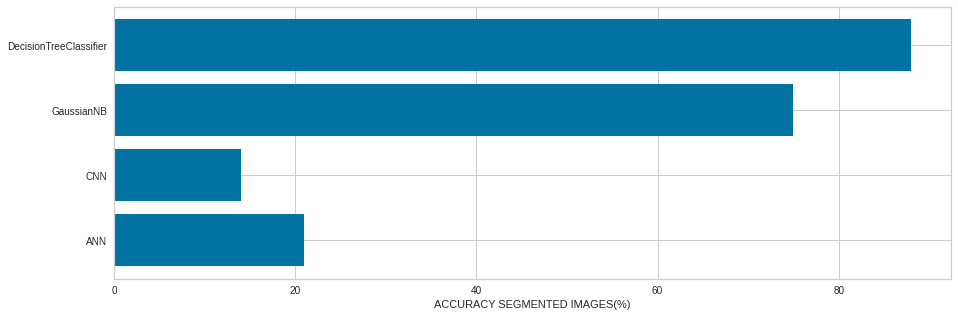

In [35]:
fig = plt.figure(figsize = (15, 5))
plt.barh(names, segmented_acc)
plt.xlabel("ACCURACY SEGMENTED IMAGES(%)")
plt.show()

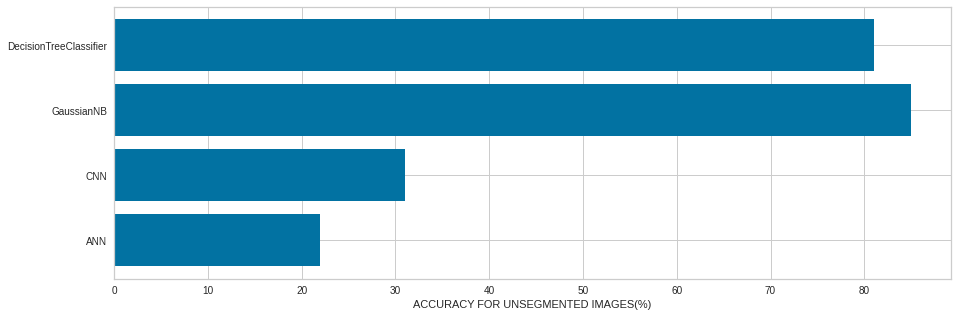

In [36]:
fig = plt.figure(figsize = (15, 5))
plt.barh(names, unsegmented_acc)
plt.xlabel("ACCURACY FOR UNSEGMENTED IMAGES(%)")
plt.show()

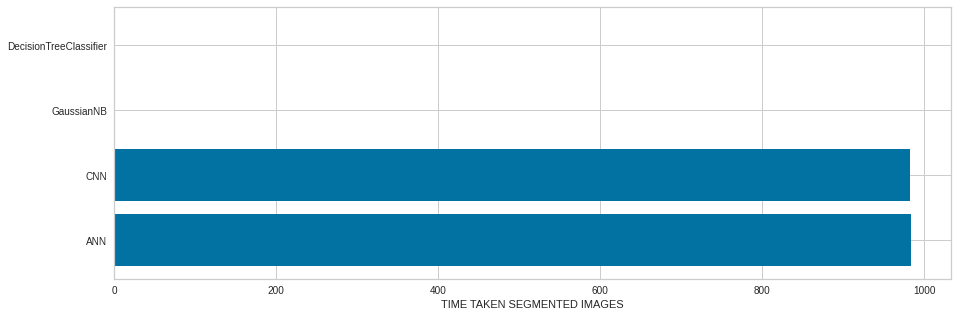

In [39]:
fig = plt.figure(figsize = (15, 5))
plt.barh(names, time_taken_segmented)
plt.xlabel("TIME TAKEN SEGMENTED IMAGES")
plt.show()

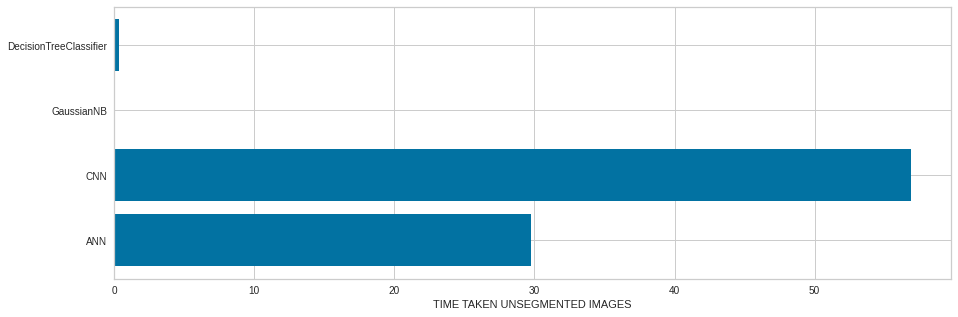

In [40]:
fig = plt.figure(figsize = (15, 5))
plt.barh(names, time_taken_unsegmented)
plt.xlabel("TIME TAKEN UNSEGMENTED IMAGES")
plt.show()